# Random Forest



#### Created on Thu Dec  7 09:38:42 2017

#### Author: tpin3694


### Import all the packages

In [1]:
import pandas as pd
import logging
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import scikitplot as skplt
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from collections import Counter
import random


### Define data reader function, to return the orederd_product_key and campaign_key columns from our data

In [2]:
def data_reader(file):
    data_read = pd.read_csv(file)
    data = data_read.drop(["Ordered_Product_Key", "Campaign_Key"], 1)
    return data

### Checks for NaNs and if any fraud actually exists in the file


In [3]:
def file_checker(dataframe):
    num_nan = np.sum(dataframe.isnull().sum())
    num_fraud = dataframe['fraud_status'].sum()
    return num_nan, num_fraud

### Uses SMOTE and Tomek Links to under and over sample to combat the class imbalance


In [4]:
def get_smote(feature, label):
    print("Raw Data: " + str(sorted(Counter(label).items())))
    smt = SMOTETomek(random_state=42)
    feature_resampled, label_resampled = smt.fit_sample(feature, label)
    print("Resampled: " + str(sorted(Counter(label_resampled).items())))
    return feature_resampled, label_resampled


### Plot socres for different trees and save the plot in the local file

In [5]:
def plotter(scores, array1, array2, tree_list, directory, file_write):
    plt.plot(tree_list, scores)
    plt.plot(tree_list, array1 + array2, 'b--')
    plt.plot(tree_list, array1 - array2, 'b--')
    plt.ylabel('CV score')
    plt.xlabel('# of trees')
    plt.savefig(directory + 'accuracy_plots/dataset' + str(file_write).strip(file_dir) + ".png")


### Calculate the model recall, precision, f1 and auc value

In [6]:
def data_scorer(model, features, labels, folds):
    recall = np.mean(cross_val_score(model, X = features, y = labels, cv = folds, scoring = "recall", n_jobs = -1))
    precision = np.mean(cross_val_score(model, X = features, y = labels, cv = folds, scoring = "precision", n_jobs = -1))
    accuracy = np.mean(cross_val_score(model, X = features, y = labels, cv = folds, scoring = "accuracy", n_jobs = -1))
    f1 = np.mean(cross_val_score(model, X = features, y = labels, cv = folds, scoring = "f1", n_jobs = -1))
    auc = np.mean(cross_val_score(model, X = features, y = labels, cv = folds, scoring = "roc_auc", n_jobs = -1))
    return accuracy, recall, precision, f1, auc 

### Define test model with features and labels

In [7]:
def test_model(no_trees, features, labels):
    random_forest = RandomForestClassifier(no_trees)
    model_metric = cross_val_score(random_forest, features, labels)
    return model_metric

### Set a seed for reproducability

In [8]:
random.seed(123)


### Setup File Structure and create a data list

In [17]:
file_dir = "/Users/sunmengnan/Documents/Github2/thgfd/data/stratified/"
files = glob.glob(file_dir + "dataset*.csv")
data_list = []

### For each file in the file list, the main process would be: read in data, then check for any fraud, for each site, split out into test and train data set, and seperate labels and features, train classifier, define variable importances, remove the umimportant variables, retrain model, check there are enough minority cases to run 10 fold cross-validation and return matrix, finally calculate prediction probabilities

In [24]:
import warnings
warnings.filterwarnings('ignore')
for file in files:
    filename = file.strip(file_dir)
    site = data_reader(file)
    file_checks = file_checker(site)
    if file_checks[1] > 0:
        train, test = train_test_split(site, test_size = 0.5, random_state = 42)
        train_x = train.loc[:, train.columns != "fraud_status"]
        train_y = train['fraud_status']
        test_x = test.loc[:, test.columns != "fraud_status"]
        test_y = test['fraud_status']
        classifier = RandomForestClassifier(80)
        classifier.fit(train_x, train_y)
        importances = pd.Series(classifier.feature_importances_, name = "Importances")
        var_importance = pd.concat([pd.Series(test_x.columns, name = "Names"), importances], 1)
        var_importance = var_importance.sort_values(by = "Importances", ascending = False).reset_index()
        var_importance = var_importance.drop("index", 1)
        sns.set_style('ticks')
        fig, ax = plt.subplots()
        fig.set_size_inches(w = 20, h = 20)
        sns.barplot(y = "Names", x = "Importances", data = var_importance, ax = ax)
        sns.despine()
        fig.savefig("/Users/sunmengnan/Desktop/FD/plot/" +
                    filename+ "variable_importance_no_smote.png")
        
        unimportant = var_importance.drop(var_importance[var_importance.Importances < 0.0001].index)
        unimportant = unimportant["Names"]
        unimportant.to_csv("/Users/sunmengnan/Desktop/FD/result/"+
                           filename + "important_variables.csv",index = True)
        
        train_x = pd.DataFrame(train_x)
        train_x.columns = train.loc[:, train.columns != "fraud_status"].columns
        train_x = train_x[unimportant]
        train_x = train_x.as_matrix()
        test_x = test[unimportant].values
        test_y = test['fraud_status'].values
        
        clf = RandomForestClassifier(80, n_jobs = -1, random_state=42)
        clf.fit(train_x, train_y)
        clf.predict(test_x)

        if sum(test_y) < 10:
            cv = sum(test_y)
        else:
            cv = 10
        
        accuracy, recall, precision, f_score, auc = data_scorer(clf, test_x, test_y, cv)
        results = [filename, accuracy, recall, precision, f_score, auc]
          
        y_prob = clf.predict_proba(test_x)
        y_pred = clf.predict(test_x)
        
        fig, ax = plt.subplots()
        fig.set_size_inches(w = 20, h = 20)
        skplt.metrics.plot_roc_curve(test_y, y_prob, title = "Random Forest ROC Site " + filename ,
                                     ax = ax, title_fontsize=46, text_fontsize = 30)
        fig.savefig("/Users/sunmengnan/Desktop/FD/plot/" + filename + "rf_roc_no_smote.png")
        
        fig, ax = plt.subplots()
        fig.set_size_inches(w = 20, h = 20)
        skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize = True, ax = ax,
                                            text_fontsize=30, title_fontsize=46, 
                                            title="Normalised Confusion Matrix")
        
        fig.savefig("/Users/sunmengnan/Desktop/FD/plot/"+ filename + "rf_confusion_no_smote.png")
        data_list.append(results)
    else:
        pass

### From the file and plots that generate, we can view the confusion matrix, taking site 11 for example,

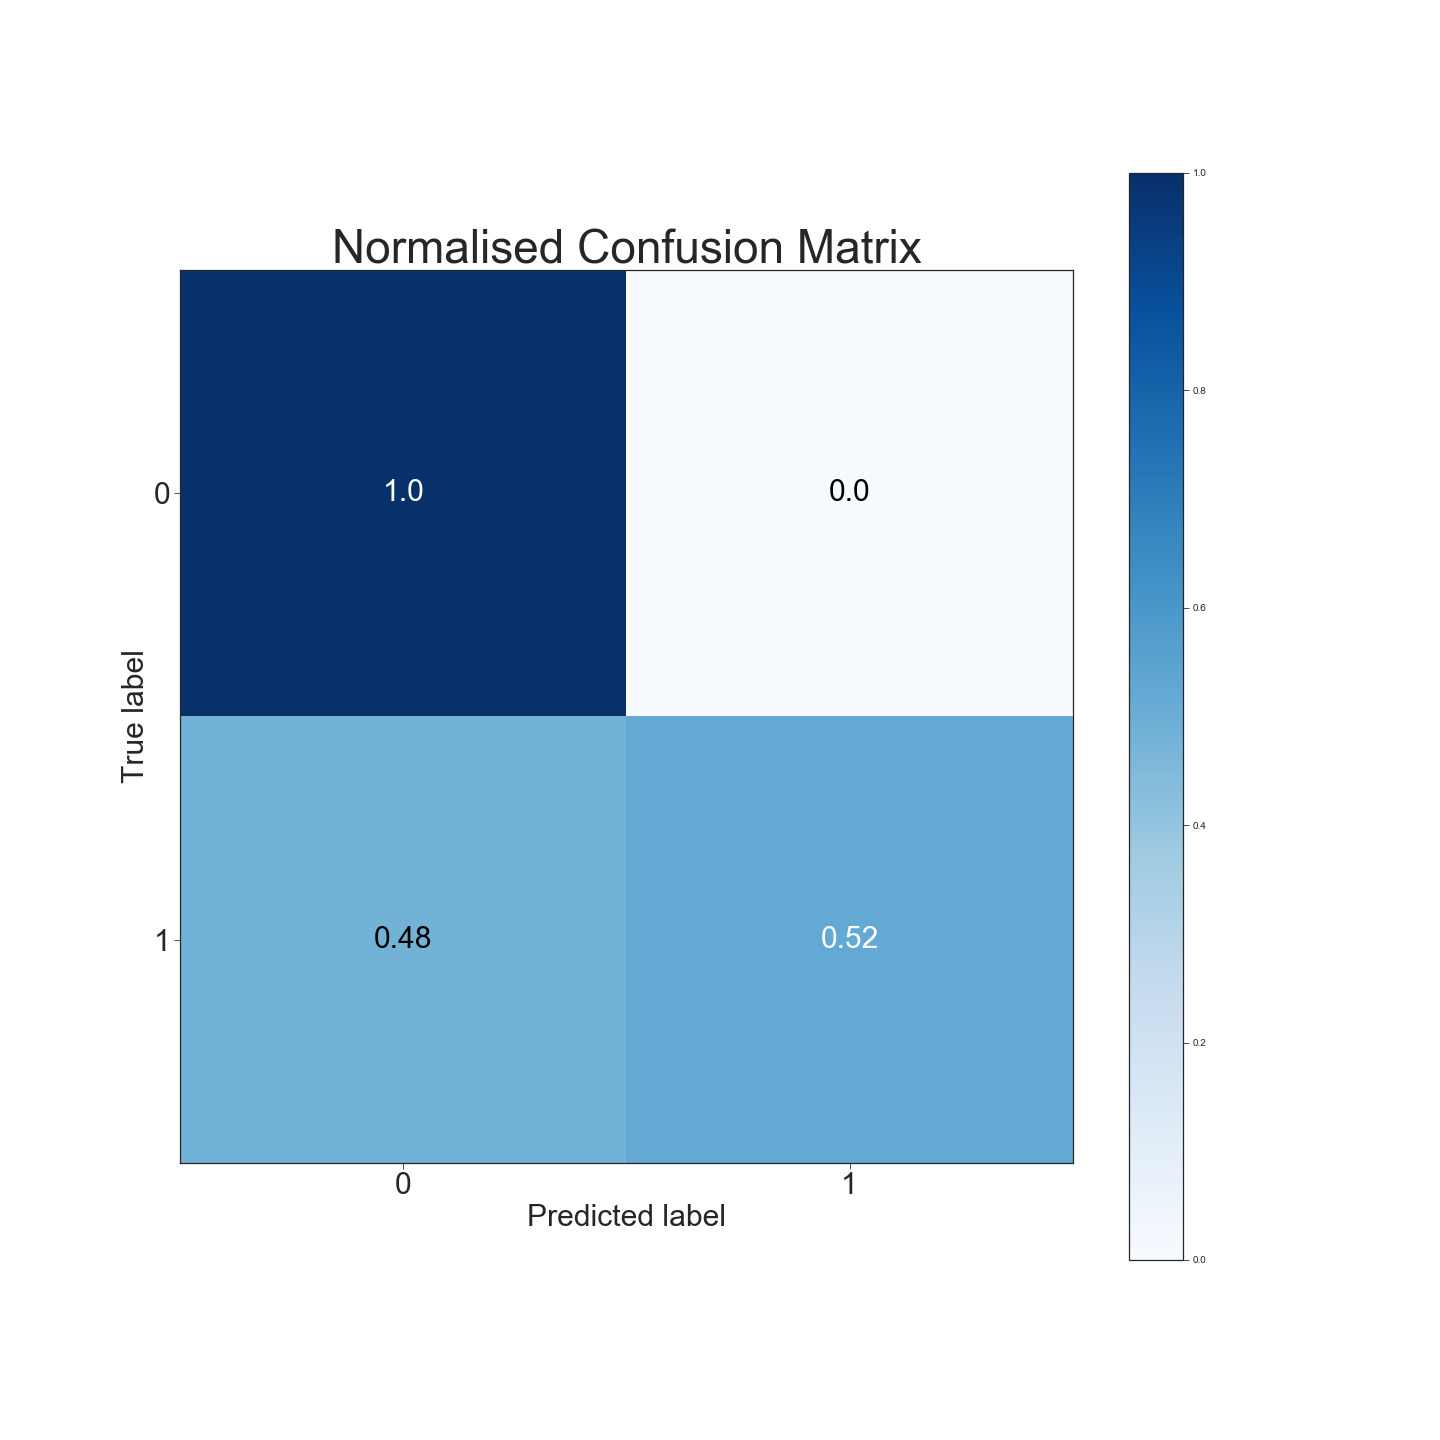

In [29]:
from IPython.display import Image
Image(filename="/Users/sunmengnan/Desktop/FD/plot/_11.csvrf_confusion_no_smote.png",width=600,height=600)

### Also, we can visualize the random forest ROC curve

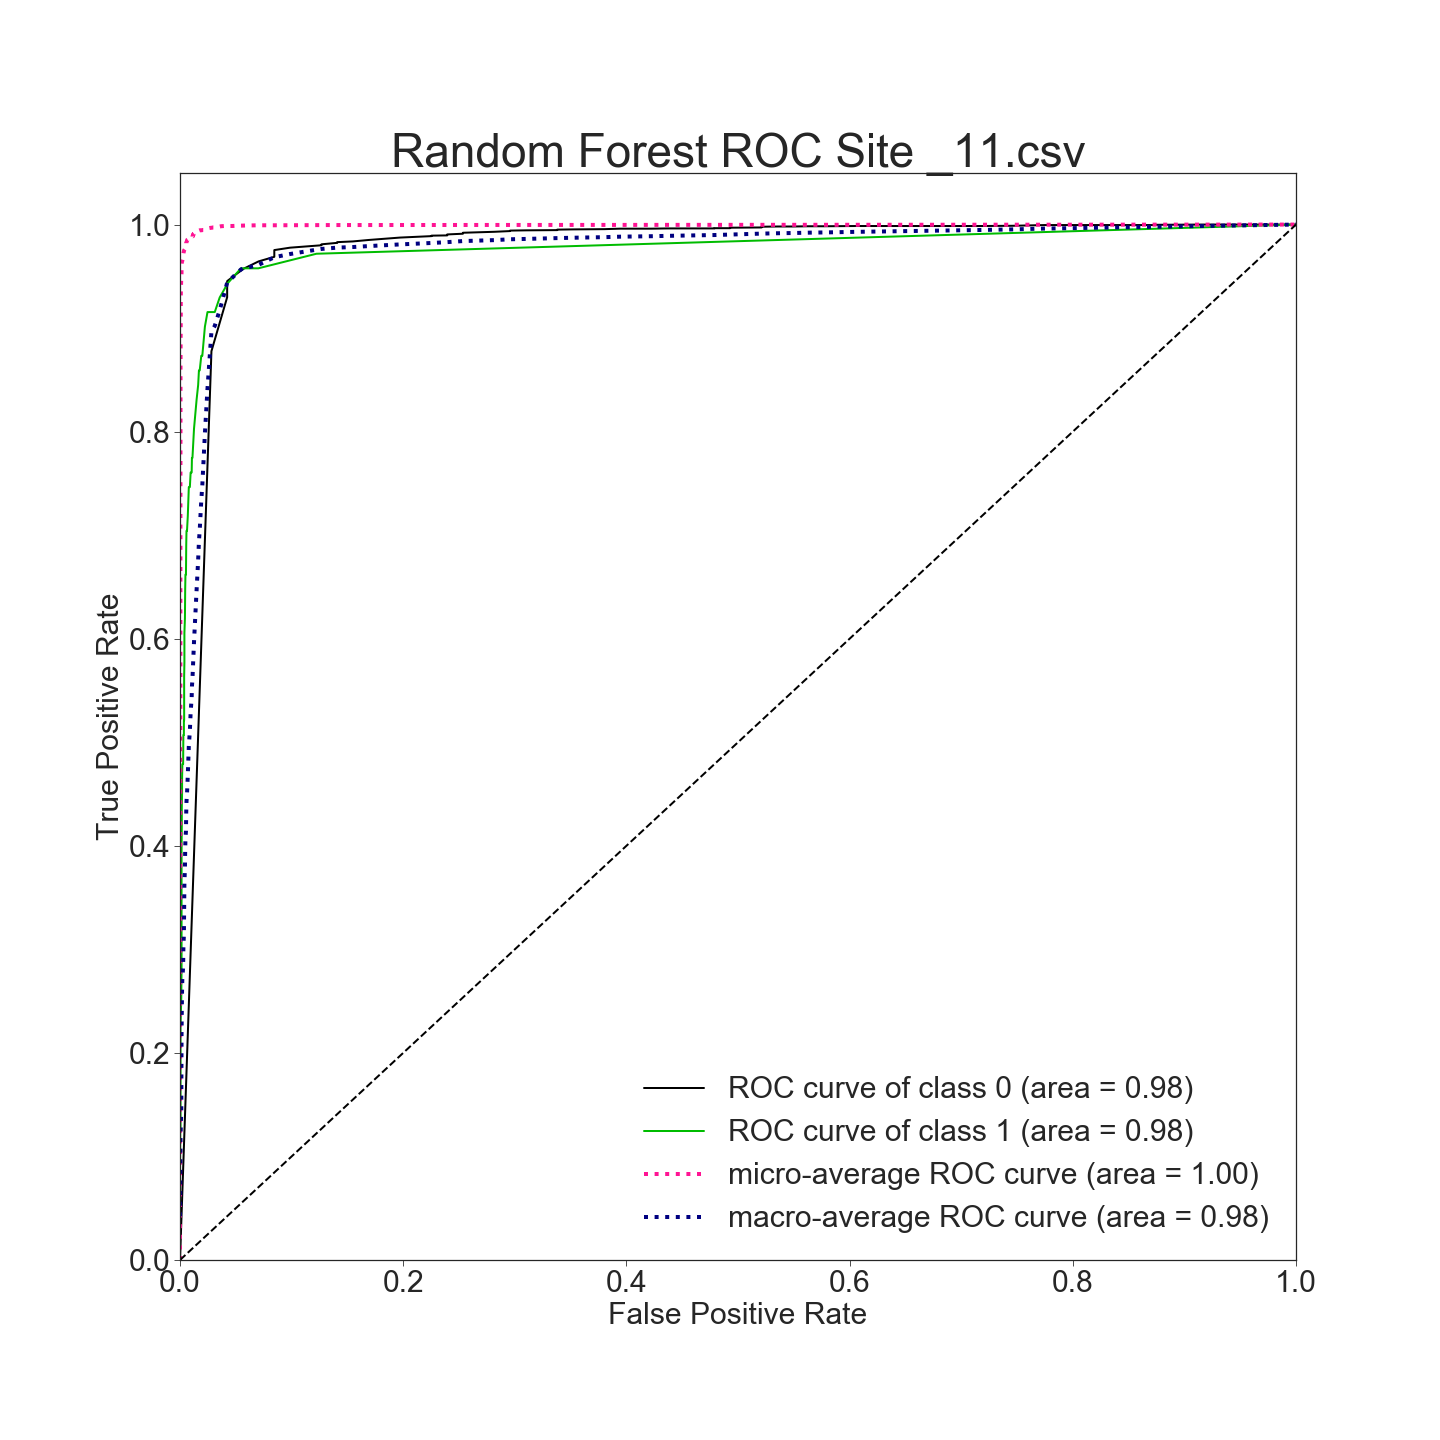

In [30]:
Image(filename="/Users/sunmengnan/Desktop/FD/plot/_11.csvrf_roc_no_smote.png",width=600,height=600)

###  Finally, we can find the most important features as followed

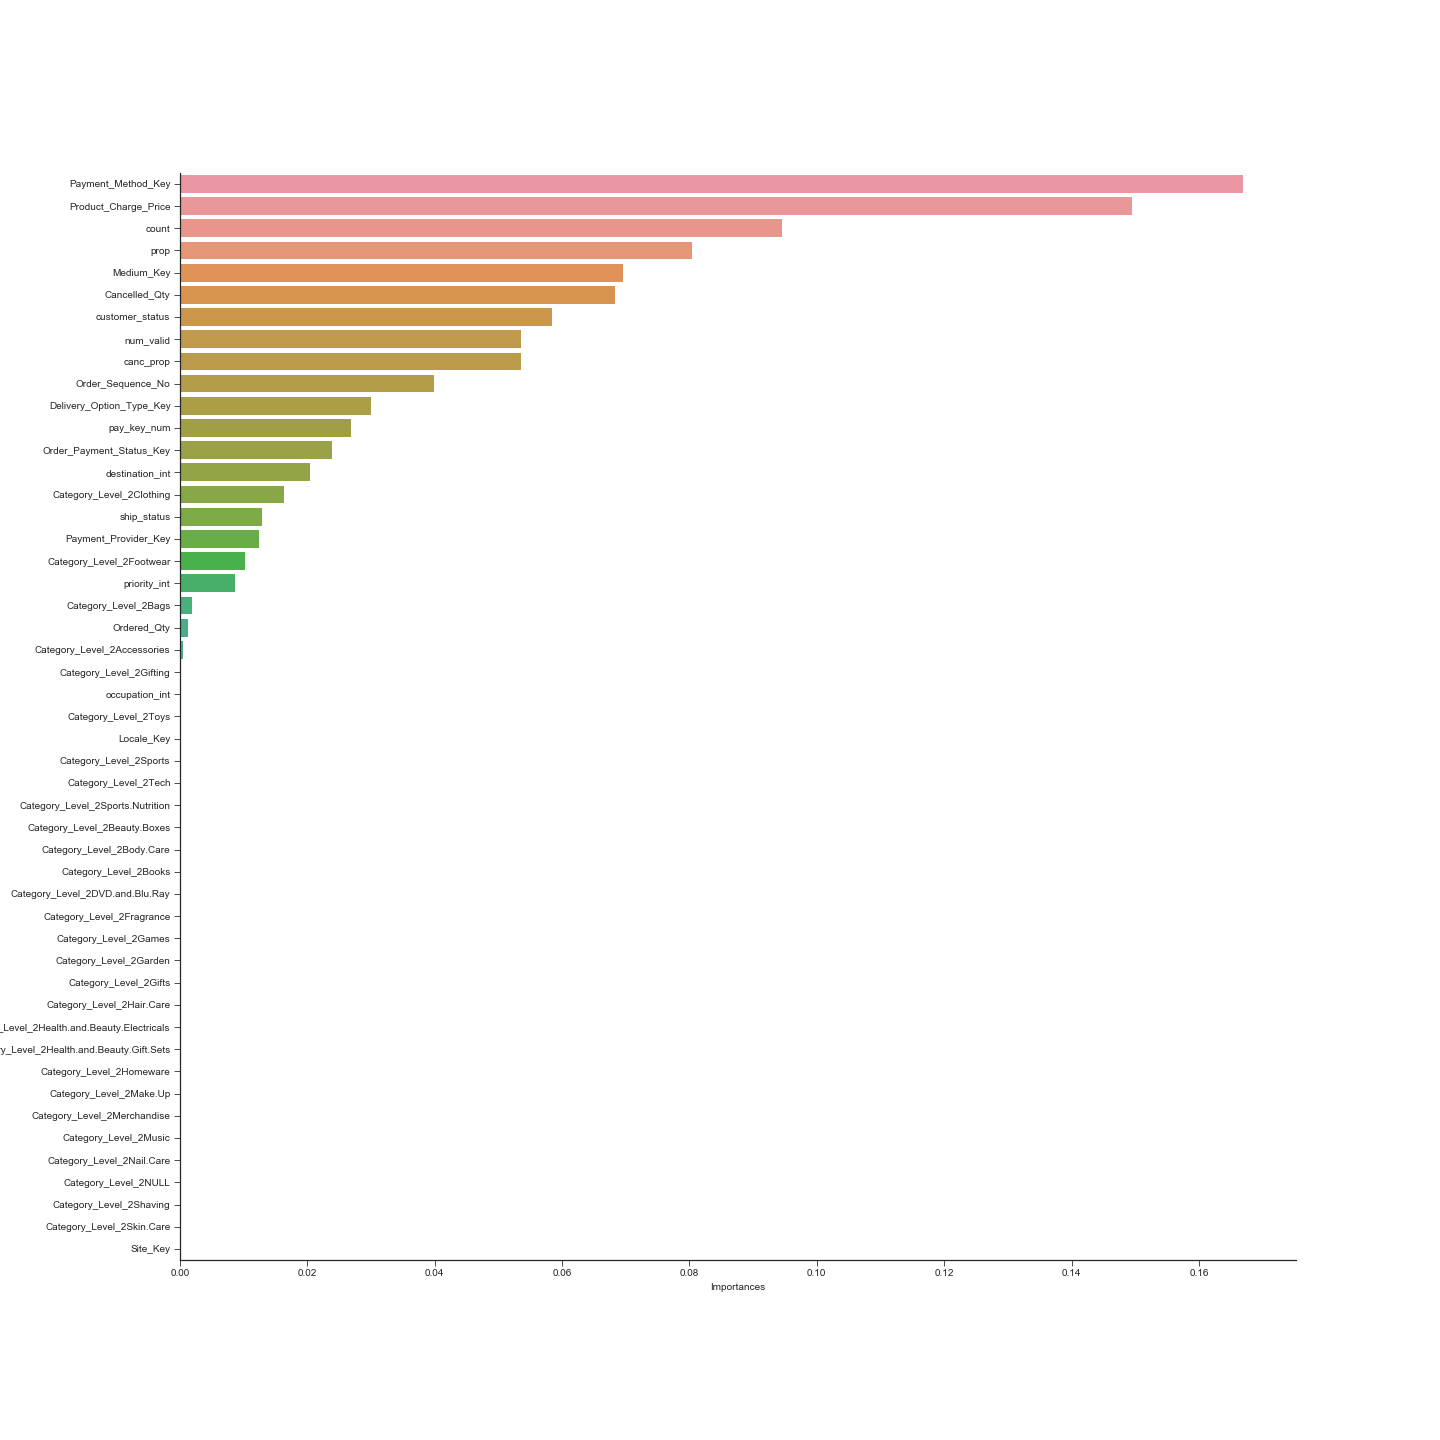

In [34]:
Image(filename="/Users/sunmengnan/Desktop/FD/plot/_11.csvvariable_importance_no_smote.png",width=1200,height=600)

### Output our result as a csv file into the local file

In [35]:
results_df = pd.DataFrame(data_list, columns = ["File","Accuracy", " recall", "precision", "f_score", "auc"])
results_df.to_csv("/Users/sunmengnan/Desktop/FD/result/random_forest_results.csv",
                  index = False)